In [2]:
import sys
sys.path.insert(0, "..")
import torch
import numpy as np
import matplotlib.pyplot as plt
import qpth
import osqp
from scipy import sparse
import pandas as pd
import time
import tqdm
from jkinpylib.utils import QP

In [3]:
class NotebookQP:
    def __init__(self, Q, p, G, h, A, b):
        self.dim = Q.shape[1]
        self.nc = G.shape[1]
        self.Q = Q
        self.p = p
        self.G = G
        self.h = h
        self.A = A
        self.b = b
    
    def solve(self, trace=True):
        x = torch.zeros(self.dim)
        trace = [x]
        working_set = torch.zeros(self.nc, dtype=torch.bool)
        converged = False
        while not converged:
            g = self.Q[0] @ x + self.p[0]

            A = self.G[0][working_set]
            b = self.h[0][working_set]
            nws = A.shape[0]
            qr = torch.linalg.qr(A.T, mode="complete")
            Y, Z = qr.Q[:, :nws], qr.Q[:, nws:]
            h = A @ x - b
            AY = A @ Y
            py = torch.linalg.solve(AY, -h)
            rhs = -Z.T @ (self.Q[0] @ Y @ py + g)
            # U_ZTGZ = torch.linalg.cholesky(Z.T @ self.Q @ Z)
            # pz = torch.cholesky_solve(rhs.reshape(-1, 1), U_ZTGZ).reshape(-1)
            pz = torch.linalg.solve(Z.T @ self.Q[0] @ Z, rhs)
            p = Z @ pz

            if torch.linalg.norm(p) < 1e-6:
                lmbd = torch.linalg.solve(AY.T, -Y.T @ (g + self.Q[0] @ p))
                print("lmbda:", lmbd)
                if torch.all(lmbd >= 0):
                    converged = True
                else:
                    big_lmbd = torch.full((self.nc,), torch.inf)
                    big_lmbd[working_set] = lmbd
                    i = torch.argmin(big_lmbd)
                    print(f"removing constraint {i}")
                    working_set[i] = False
                    continue

            mask = torch.logical_and(torch.logical_not(working_set), self.G[0] @ p > 0)
            alpha, i = torch.min(torch.where(mask, (self.h[0] - self.G[0] @ x) / (self.G[0] @ p), torch.inf), dim=0)
            if alpha < 1:
                print(f"adding constraint {i}")
                working_set[i] = True
            else:
                alpha.reshape(-1)[:] = 1
            x = x + alpha * p
            trace.append(x.unsqueeze(0).unsqueeze(2))

        return x.unsqueeze(0).unsqueeze(2), trace

trace 0: [0. 0.]
trace 1: [0.13085063 0.99999994]
trace 2: [0.         0.99999994]
trace 3: [0.         0.99999994]


/Users/drm/Library/Caches/pypoetry/virtualenvs/jkinpylib-85zxWVKj-py3.8/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


<Axes: >

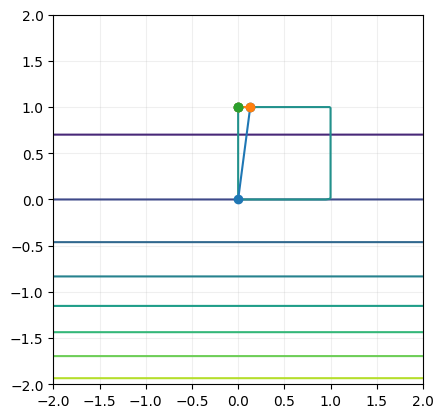

In [5]:
def plot_qp(ax: plt.Axes, qp):
    xs = ys = np.linspace(-2, 2, num=100)
    XS, YS = np.meshgrid(xs, ys)
    x = np.stack((XS.flatten(), YS.flatten()))
    Q, p = qp.Q[0].cpu().numpy(), np.expand_dims(qp.p.flatten().cpu().numpy(), 1)
    ZS = np.sum(x * (Q/2 @ x), axis=0) + np.sum(x * p, axis=0)
    ZS = ZS.reshape(XS.shape)
    ax.contour(XS, YS, ZS)

    if qp.G is not None:
        G, h = qp.G[0].cpu().numpy(), qp.h.flatten().cpu().numpy()
        ax.contour(XS, YS, np.max(G @ x - np.expand_dims(h, 1), axis=0).reshape(XS.shape), levels=0)
    
    sol, trace = qp.solve(trace=True)
    for i, trace_x in enumerate(trace):
        print(f"trace {i}: {trace_x.squeeze().numpy()}")
    for i in range(1, len(trace)):
        (x0, y0), (x1, y1) = trace[i-1][0, :], trace[i][0, :]
        ax.plot([x0, x1], [y0, y1], marker="o")
    ax.scatter([sol[0, 0]], [sol[0, 1]])

    return ax

ax = plt.subplot(111)
ax.set_aspect(1)
ax.grid(alpha=0.2)

dim = 2
torch.manual_seed(1234)
Q = torch.eye(dim)
p = 2 * torch.ones(dim)

nc = 8
Q = torch.eye(dim)
p = 2 * torch.ones(dim)
G = torch.randn((nc, dim))
h = torch.ones(nc)
p = torch.tensor([4, 0], dtype=torch.float32)
# nc = 4
# G = torch.tensor([[1, 0], [0, 1], [-1, 0], [0, -1]], dtype=torch.float32)
# h = torch.tensor([1, 1, 1, 1], dtype=torch.float32)
Q, p, G, h = Q.unsqueeze(0), p.unsqueeze(0), G.unsqueeze(0), h.unsqueeze(0)
qp = QP(2 * Q, p, G, h, None, None)
plot_qp(ax, qp)

In [15]:
dimrange = [4]
torch.manual_seed(1232)
ntrials = 50
df = pd.DataFrame(columns=[
    "dim",
    "batch_size",
    "trial_id",
    "oursol_time",
    "oursol_err",
    "qpthsol_time",
    "qpthsol_err",
    "osqp_time",
    "osqp_err",
])
for dim in dimrange:
    for batch_size in tqdm.tqdm(range(1, 128, 4)):
        for trial in range(ntrials):
            Q = torch.eye(dim).expand(batch_size, dim, dim)
            p = 2 * torch.ones((batch_size, dim))

            nc = 2 * dim
            G = torch.randn((batch_size, nc, dim))
            h = torch.ones((batch_size, nc))
            # nc = 4
            # G = torch.tensor([[1, 0], [0, 1], [-1, 0], [0, -1]], dtype=torch.float32)
            # h = torch.tensor([1, 1, 1, 1], dtype=torch.float32)
            start = time.time()
            qp = QP(2 * Q, p, G, h, None, None)
            oursol = qp.solve()
            oursoltime = time.time() - start

            start = time.time()
            qpthsol = qpth.qp.QPFunction(verbose=False)(2 * Q, p, G, h, torch.Tensor(), torch.Tensor())
            qpthsoltime = time.time() - start

            start = time.time()
            osqpsol = torch.zeros_like(oursol)
            for i in range(batch_size):
                prob = osqp.OSQP()
                prob.setup(sparse.csc_matrix(2*Q[i].cpu().numpy()), p[i].cpu().numpy(), sparse.csc_matrix(G[i].cpu().numpy()), -np.inf * np.ones_like(h[i]), h[i].cpu().numpy(), verbose=False)
                osqpsol[i] = torch.tensor(prob.solve().x)
            osqpsoltime = time.time() - start

            osqperror = 0
            # Compute error as mean squared error across batch
            qptherror = torch.mean((qpthsol - osqpsol) ** 2)
            ourerror = torch.mean((oursol - osqpsol) ** 2)

            df.loc[len(df)] = [dim, batch_size, trial, oursoltime, ourerror, qpthsoltime, qptherror, osqpsoltime, osqperror]

 41%|████      | 13/32 [00:14<00:27,  1.45s/it]


--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------



 94%|█████████▍| 30/32 [00:53<00:05,  2.66s/it]


--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------



100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


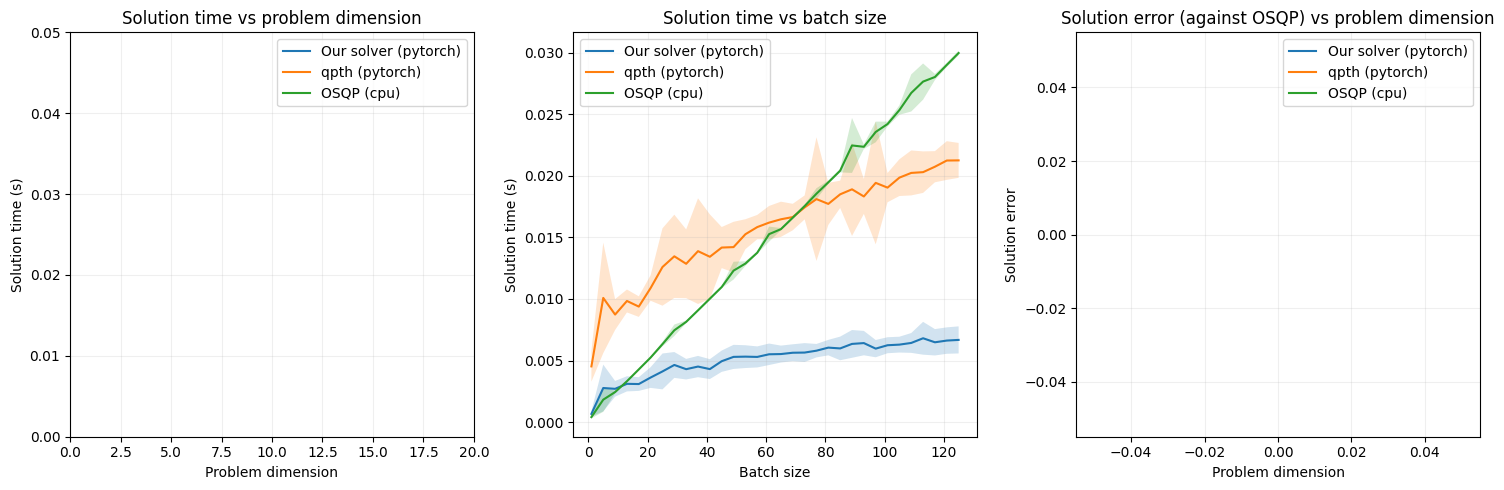

In [16]:
# plot of solution time vs problem dimension, next to plot of solution error vs
# problem dimension, for a given batch size

batch_size = 128 
dfbatch = df[df["batch_size"] == batch_size]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.title = f"Batch size {batch_size}"
axes[0].set_title("Solution time vs problem dimension")
axes[0].set_xlabel("Problem dimension")
axes[0].set_ylabel("Solution time (s)")
axes[0].set_ylim(0, 0.05)
axes[0].set_xlim(0, 20)
axes[0].grid(alpha=0.2)
axes[0].plot(dfbatch.groupby("dim").mean()["oursol_time"], label="Our solver (pytorch)")
axes[0].plot(dfbatch.groupby("dim").mean()["qpthsol_time"], label="qpth (pytorch)")
axes[0].plot(dfbatch.groupby("dim").mean()["osqp_time"], label="OSQP (cpu)")
# plot standard deviation as a shaded region
axes[0].fill_between(dfbatch.groupby("dim").mean()["oursol_time"].index, dfbatch.groupby("dim").mean()["oursol_time"] - dfbatch.groupby("dim").std()["oursol_time"], dfbatch.groupby("dim").mean()["oursol_time"] + dfbatch.groupby("dim").std()["oursol_time"], alpha=0.2)
axes[0].fill_between(dfbatch.groupby("dim").mean()["qpthsol_time"].index, dfbatch.groupby("dim").mean()["qpthsol_time"] - dfbatch.groupby("dim").std()["qpthsol_time"], dfbatch.groupby("dim").mean()["qpthsol_time"] + dfbatch.groupby("dim").std()["qpthsol_time"], alpha=0.2)
axes[0].fill_between(dfbatch.groupby("dim").mean()["osqp_time"].index, dfbatch.groupby("dim").mean()["osqp_time"] - dfbatch.groupby("dim").std()["osqp_time"], dfbatch.groupby("dim").mean()["osqp_time"] + dfbatch.groupby("dim").std()["osqp_time"], alpha=0.2)
axes[0].legend()

# plot of solution time vs batch_size, for a given problem dimension
dim = 4
dfdim = df[df["dim"] == dim]

axes[1].set_title("Solution time vs batch size")
axes[1].set_xlabel("Batch size")
axes[1].set_ylabel("Solution time (s)")
#axes[1].set_ylim(0, 0.05)
#axes[1].set_xlim(0, 200)
axes[1].grid(alpha=0.2)
axes[1].plot(dfdim.groupby("batch_size").mean()["oursol_time"], label="Our solver (pytorch)")
axes[1].plot(dfdim.groupby("batch_size").mean()["qpthsol_time"], label="qpth (pytorch)")
axes[1].plot(dfdim.groupby("batch_size").mean()["osqp_time"], label="OSQP (cpu)")
# plot standard deviation as a shaded region
axes[1].fill_between(dfdim.groupby("batch_size").mean()["oursol_time"].index, dfdim.groupby("batch_size").mean()["oursol_time"] - dfdim.groupby("batch_size").std()["oursol_time"], dfdim.groupby("batch_size").mean()["oursol_time"] + dfdim.groupby("batch_size").std()["oursol_time"], alpha=0.2)
axes[1].fill_between(dfdim.groupby("batch_size").mean()["qpthsol_time"].index, dfdim.groupby("batch_size").mean()["qpthsol_time"] - dfdim.groupby("batch_size").std()["qpthsol_time"], dfdim.groupby("batch_size").mean()["qpthsol_time"] + dfdim.groupby("batch_size").std()["qpthsol_time"], alpha=0.2)
axes[1].fill_between(dfdim.groupby("batch_size").mean()["osqp_time"].index, dfdim.groupby("batch_size").mean()["osqp_time"] - dfdim.groupby("batch_size").std()["osqp_time"], dfdim.groupby("batch_size").mean()["osqp_time"] + dfdim.groupby("batch_size").std()["osqp_time"], alpha=0.2)
axes[1].legend()

axes[2].set_title("Solution error (against OSQP) vs problem dimension")
axes[2].set_xlabel("Problem dimension")
axes[2].set_ylabel("Solution error")
axes[2].grid(alpha=0.2)
axes[2].plot(dfbatch.groupby("dim").mean()["oursol_err"], label="Our solver (pytorch)")
axes[2].plot(dfbatch.groupby("dim").mean()["qpthsol_err"], label="qpth (pytorch)")
axes[2].plot(dfbatch.groupby("dim").mean()["osqp_err"], label="OSQP (cpu)")
axes[2].legend()

plt.tight_layout()